Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
Iter-0; Loss: 800.7
Iter-1000; Loss: 141.6
Iter-2000; Loss: 129.4
Iter-3000; Loss: 120.0
Iter-4000; Loss: 116.0
Iter-5000; Loss: 112.9
Iter-6000; Loss: 108.3
Iter-7000; Loss: 115.3
Iter-8000; Loss: 114.2
Iter-9000; Loss: 104.9


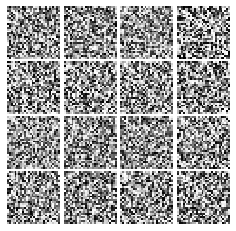

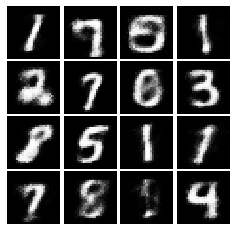

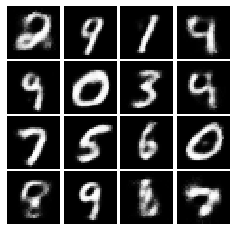

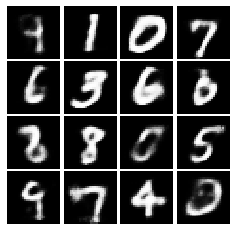

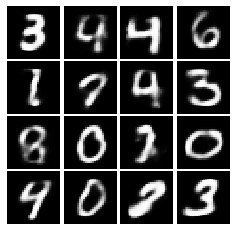

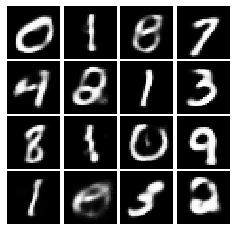

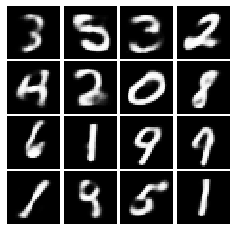

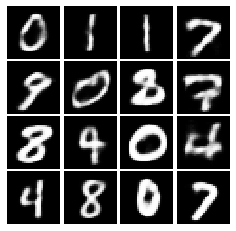

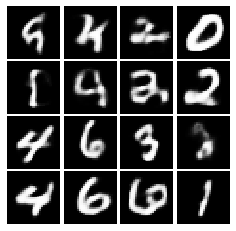

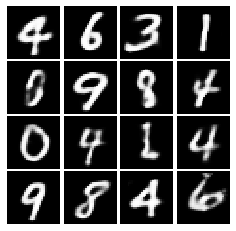

In [4]:
#source: https://wiseodd.github.io/techblog/2017/01/24/vae-pytorch/

import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)
mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)


# =============================== Q(z|X) ======================================

Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)


def Q(X):
    h = nn.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    z_mu = h @ Whz_mu + bhz_mu.repeat(h.size(0), 1)
    z_var = h @ Whz_var + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var


def sample_z(mu, log_var):
    eps = Variable(torch.randn(mb_size, Z_dim))
    return mu + torch.exp(log_var / 2) * eps


# =============================== P(X|z) ======================================

Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def P(z):
    h = nn.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X


# =============================== TRAINING ====================================

params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var,
          Wzh, bzh, Whx, bhx]

solver = optim.Adam(params, lr=lr)

for it in range(10000):
    X, _ = mnist.train.next_batch(mb_size)
    X = Variable(torch.from_numpy(X))

    # Forward
    z_mu, z_var = Q(X)
    z = sample_z(z_mu, z_var)
    X_sample = P(z)

    # Loss
    recon_loss = nn.binary_cross_entropy(X_sample, X, size_average=False) / mb_size
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
    loss = recon_loss + kl_loss

    # Backward
    loss.backward()

    # Update
    solver.step()

    # Housekeeping
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; Loss: {:.4}'.format(it, loss.data.item()))

        samples = P(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        #plt.savefig('out/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
        c += 1
        #plt.close(fig)
plt.show()